# First Analysis
## Only Offshore wind, no production in Belgium

In [22]:
from gboml import GbomlGraph

timehorizon = 8760


gboml_model = GbomlGraph(timehorizon=timehorizon)
nodes, edges, param = gboml_model.import_all_nodes_and_edges("../../models/base/greenland_simple.gboml")
gboml_model.add_global_parameters(param)
gboml_model.add_nodes_in_model(*nodes)
gboml_model.add_hyperedges_in_model(*edges)
gboml_model.build_model()
solution, obj, status, solver_info, constr_info, _ = gboml_model.solve_gurobi()
print("Solved")

Check variables of node LIQUEFIED_METHANE_CARRIERS_GR : --- 0.0 seconds ---
Check variables of node LIQUEFIED_METHANE_STORAGE_HUB_GR : --- 0.0 seconds ---
Check variables of node METHANE_LIQUEFACTION_PLANTS_GR : --- 0.0 seconds ---
Check variables of node METHANATION_PLANTS_GR : --- 0.0 seconds ---
Check variables of node WATER_STORAGE_GR : --- 0.0 seconds ---
Check variables of node CARBON_DIOXIDE_STORAGE_GR : --- 0.0 seconds ---
Check variables of node HYDROGEN_STORAGE_GR : --- 0.0 seconds ---
Check variables of node DIRECT_AIR_CAPTURE_PLANTS_GR : --- 0.0 seconds ---
Check variables of node DESALINATION_PLANTS_GR : --- 0.0 seconds ---
Check variables of node ELECTROLYSIS_PLANTS_GR : --- 0.0 seconds ---
Check variables of node HVDC_GR : --- 0.0 seconds ---
Check variables of node BATTERY_STORAGE_GR : --- 0.0 seconds ---
Check variables of node ON_WIND_PLANTS_GR : --- 0.0 seconds ---
Check variables of node OFF_WIND_PLANTS_GR : --- 0.0 seconds ---
Check variables of node CO2_EXPORT : -

   14026 DPushes remaining with DInf 1.8987928e-04                65s
   13400 DPushes remaining with DInf 1.8987928e-04                71s
   12774 DPushes remaining with DInf 1.8987928e-04                77s
   12461 DPushes remaining with DInf 1.8987928e-04                80s
   11835 DPushes remaining with DInf 1.8987928e-04                87s
   11209 DPushes remaining with DInf 1.8987928e-04                93s
   10896 DPushes remaining with DInf 1.8987928e-04                96s
   10270 DPushes remaining with DInf 1.8987928e-04               102s
    9957 DPushes remaining with DInf 1.8987928e-04               106s
    9331 DPushes remaining with DInf 1.8987928e-04               113s
    9018 DPushes remaining with DInf 1.8987928e-04               116s
       0 DPushes remaining with DInf 1.8987928e-04               119s

   26236 PPushes remaining with PInf 0.0000000e+00               119s
   19397 PPushes remaining with PInf 0.0000000e+00               125s
    3823 PPushes re

In [23]:
import json

gathered_data = gboml_model.turn_solution_to_dictionary(solver_info, status, solution, obj, constr_info)
print("Json done")
with open(f'../../models/base/results/RREH.json', "w") as fp:json.dump(gathered_data, fp, indent=4)

Json done


In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [25]:
class MakeMeReadable:
    def __init__(self, d):
        self.d = d
    
    def __dir__(self):
        return self.d.keys()
    
    def __getattr__(self, v):
        try:
            out = self.d[v]
            if isinstance(out, dict):
                return MakeMeReadable(out)
            return out
        except:
            return getattr(self.d, v)
        
    def __str__(self):
        return str(self.d)
    
    def __repr__(self):
        return repr(self.d)

In [26]:
dico = {}
with open('../../models/base/results/RREH.json', 'r') as f:
    dico = json.load(f)
            
d = MakeMeReadable(dico)
    
if isinstance(dico, dict):
    print('The data is a dictionary')
else:
    print('The data is not a dictionary')

The data is a dictionary


In [27]:
wind_capacity = d.solution.elements.OFF_WIND_PLANTS_GR.variables.capacity.values
wind_capacity

[63.72165113369946]

In [28]:
np.mean(wind_prod)

34.69348502222155

In [29]:
def cost_rreh(ls:list):
    if len(ls) == 0:
        return 0.0

    cost = 0

    for ele in ls:
        # print(f"{ele = }")
        # print(dico["solution"]["elements"][ele]["objectives"])
        try:
            cost += np.sum(dico["solution"]["elements"][ele]["objectives"]["unnamed"])
        except:
            for e in dico["solution"]["elements"][ele]["objectives"]["named"].values():
                # print(f"{e = }")
                cost += e
        # print(f"{cost = }")
    
    return cost

In [30]:
ls_nodes = list(d.model.nodes.keys())

print(ls_nodes)

['LIQUEFIED_METHANE_CARRIERS_GR', 'LIQUEFIED_METHANE_STORAGE_HUB_GR', 'METHANE_LIQUEFACTION_PLANTS_GR', 'METHANATION_PLANTS_GR', 'WATER_STORAGE_GR', 'CARBON_DIOXIDE_STORAGE_GR', 'HYDROGEN_STORAGE_GR', 'DIRECT_AIR_CAPTURE_PLANTS_GR', 'DESALINATION_PLANTS_GR', 'ELECTROLYSIS_PLANTS_GR', 'HVDC_GR', 'BATTERY_STORAGE_GR', 'ON_WIND_PLANTS_GR', 'OFF_WIND_PLANTS_GR', 'CO2_EXPORT', 'CARBON_DIOXIDE_STORAGE_BE', 'CARRIER_CO2_GR', 'PIPE_CO2_GR', 'PROD_CO2', 'PCCC', 'ENERGY_DEMAND_BE', 'LIQUEFIED_METHANE_STORAGE_DESTINATION', 'LIQUEFIED_METHANE_REGASIFICATION']


In [31]:
try:
    GR_nodes = list(map(lambda string: string if string[-3:] == "_GR" else None, ls_nodes))
except:
    GR_nodes = []
BE_nodes = list(map(lambda string: string if string[-3:] == "_BE" or string in ["PCCC_CCGT", "PCCC", "CO2_EXPORT", "LIQUEFIED_METHANE_STORAGE_DESTINATION","LIQUEFIED_METHANE_REGASIFICATION"] else None, ls_nodes))

try:
    GR_nodes = list(filter(lambda x: x not in [None, "PCCC", "PROD_CO2", "CO2_EXPORT"], GR_nodes))
except:
    GR_nodes = []
BE_nodes = list(filter(lambda x: x not in [None, "PROD_CO2"], BE_nodes))

cost_GR = cost_rreh(GR_nodes)
cost_BE = cost_rreh(BE_nodes)


print(f"GR {cost_GR = }")
print(f"BE {cost_BE = }")


obj_cost = d.solution.objective
tot_cost = np.sum([cost_GR, cost_BE])

abs_diff = np.abs(d.solution.objective - np.sum([cost_GR, cost_BE]))
print(f"{obj_cost = }")
print(f"{tot_cost = }")
print(abs_diff < 0.1)

GR cost_GR = 31106.522418539564
BE cost_BE = 730.9522665262955
obj_cost = 31837.474685065354
tot_cost = 31837.47468506586
True


In [32]:
wind_onshore_gr = d.solution.elements.ON_WIND_PLANTS_GR.variables.capacity.values[0]
wind_off_gr = d.solution.elements.OFF_WIND_PLANTS_GR.variables.capacity.values[0]

total_installed_capacity = wind_onshore_gr + wind_off_gr

Installed capacity of onshore = 0.0 MW
Installed capacity of offshore = 63.72165113369946 MW
Total installed capacity = 63.72165113369946 MW


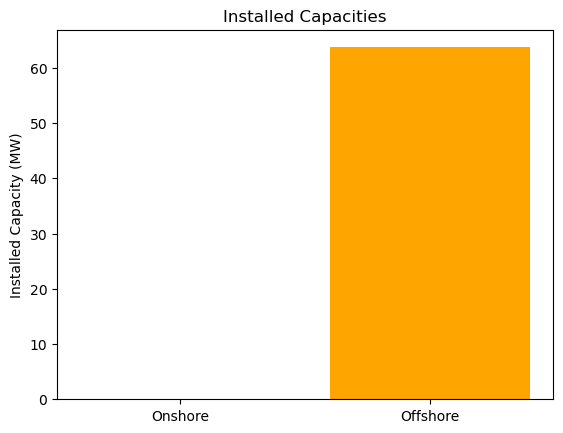

In [33]:
# Print the installed capacities and total
print(f"Installed capacity of onshore = {wind_onshore_gr} MW")
print(f"Installed capacity of offshore = {wind_off_gr} MW")
print(f"Total installed capacity = {total_installed_capacity} MW")

# Plotting
labels = ['Onshore', 'Offshore']
values = [wind_onshore_gr, wind_off_gr]

plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Installed Capacity (MW)')
plt.title('Installed Capacities')
plt.show()

Text(0.5, 1.0, 'Electricity produced')

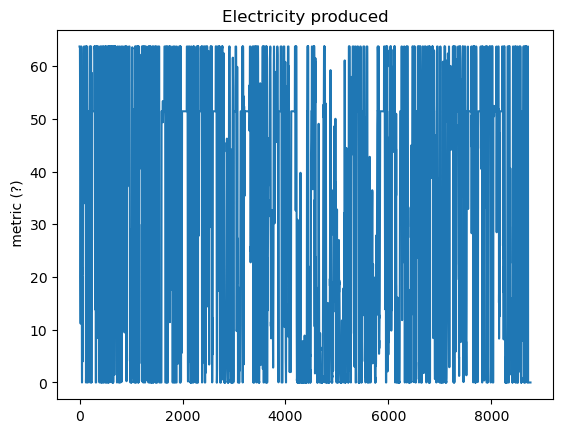

In [52]:
wind_prod = d.solution.elements.OFF_WIND_PLANTS_GR.variables.electricity.values
plt.plot(wind_prod)
plt.ylabel(' metric (?)')
plt.title('Electricity produced')

In [38]:
elec_demand_pccc = np.array(d.solution.elements.PCCC.variables.e_consumed.values)
elec_demand_pccc

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
co2_export = np.array(d.solution.elements.CO2_EXPORT.variables.exported.values)
co2_storage_be_in = np.array(d.solution.elements.CARBON_DIOXIDE_STORAGE_BE.variables.carbon_dioxide_in.values)
co2_storage_be_out = np.array(d.solution.elements.CARBON_DIOXIDE_STORAGE_BE.variables.carbon_dioxide_out.values)

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
print(co2_export)
print(co2_storage_be_in)
print(co2_storage_be_out)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
